# Analyse Isopeptor's scan on the AFDB

In [1]:
import pandas as pd
import os
import glob
import seaborn as sns 
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import matplotlib as mpl
import sys
sys.path.append("../bin")
from constants import NON_ISOPEP_DOMAINS as non_isopep
from constants import ISOPEP_DOMAINS as isopep
from sequence import find_sortase
from dotenv import load_dotenv
load_dotenv("../.env")
pd.set_option('display.max_columns', None)

In [2]:
AFDB_JESS_SCAN_TABLE = os.getenv("AFDB_JESS_SCAN_TABLE")
AFDB_DOMAINS= os.getenv("AFDB_DOMAINS")
AFDB_SCAN_SEQS = os.getenv("AFDB_SCAN_SEQS")
FA_PRED = os.getenv("FA_PRED")
ADH_TABLE = os.getenv("ADH_TABLE")
STALK_TABLE = os.getenv("STALK_TABLE")
PATHOGENS = os.getenv("PATHOGENS")
PDB_BIOCHEM = os.getenv("PDB_BIOCHEM")
TABLE = os.getenv("TABLE")

df = pd.read_csv(TABLE)
str_df = pd.read_csv(AFDB_JESS_SCAN_TABLE)
strd_df = pd.read_csv(AFDB_DOMAINS)
str_df["mean_plddt"] = str_df[["r1_plddt", "r2_plddt", "r3_plddt"]].mean(axis=1)

seq_df = pd.read_csv(AFDB_SCAN_SEQS)
seq_df["seq_len"] = seq_df["sequence"].apply(len)

pdb_df = pd.read_csv(PDB_BIOCHEM)

In [3]:
# Find sortase motifs
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"]=="Bacteria")&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
sub_df = seq_df[(seq_df["uniprot_acc"].isin(ib_proteins))].copy()
sub_df["Sortase motif"] = sub_df["sequence"].apply(find_sortase)

# Add to domains database
strd_df = pd.concat([strd_df, sub_df[(sub_df["Sortase motif"])][["uniprot_acc"]]\
        .assign(pfamA_id="Sortase motif")\
        .assign(pfamA_acc="PFXXXXX")[["uniprot_acc", "pfamA_acc", "pfamA_id"]]])

## General plots

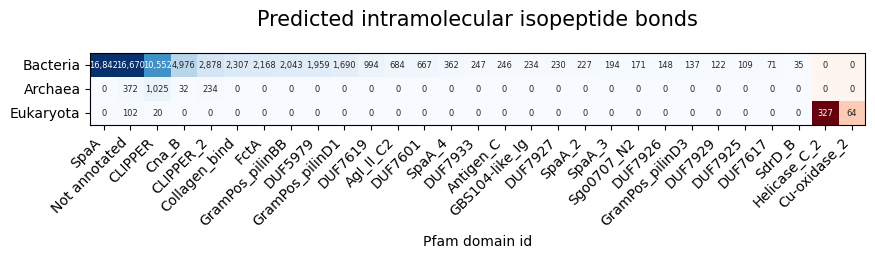

In [6]:
# Plot now 

plot_df = str_df[(str_df["probability"]>.65)&(~str_df["taxonomy"].isna())].copy()
plot_df["pfamA_id"] = plot_df["pfamA_id"].fillna("Not annotated")
plot_df["pfamA_id"] = plot_df["pfamA_id"].replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"})
plot_df = plot_df.value_counts(["kingdom", "pfamA_id"]).reset_index()\
                 .query('count>=20&kingdom!="unclassified sequences"')\
                 .pivot(index="pfamA_id", columns="kingdom", values="count").fillna(0).astype(int)\
                 [["Bacteria", "Archaea", "Eukaryota"]]\
                 .sort_values(["Bacteria", "Archaea", "Eukaryota"], ascending=[False, False, False]).T\
                 .fillna(0)

false_positive_ids = ["Cu-oxidase_2", "DeoC", "TRAP_beta", "Ion_trans", "CarboxypepD_reg", "Helicase_C_2"]

# Create masks for false positives and non-false positives (columns-based)
false_positive_mask = plot_df.columns.isin(false_positive_ids)

# Separate data into two layers: false positives and non-false positives
false_positives_layer = plot_df.astype(float).copy()
false_positives_layer.loc[:, ~false_positive_mask] = np.nan  # Keep only false positives

non_false_positives_layer = plot_df.astype(float).copy()
non_false_positives_layer.loc[:, false_positive_mask] = np.nan  # Exclude false positives

# Create colormaps with custom "under" or "over" values
cmap_false_positives = plt.get_cmap("Reds").copy()
cmap_false_positives.set_under("none")  # Make non-values invisible

cmap_non_false_positives = plt.get_cmap("Blues").copy()
cmap_non_false_positives.set_under("none")  # Make non-values invisible

fig, ax = plt.subplots(figsize=[10,5])

sns.heatmap(non_false_positives_layer, cmap=cmap_non_false_positives, 
            ax=ax, annot=True, annot_kws={'fontsize': 6}, fmt=",.0f", cbar=False)

sns.heatmap(false_positives_layer, cmap=cmap_false_positives, 
            ax=ax, annot=True, annot_kws={'fontsize': 6}, fmt=",.0f", cbar=False)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_aspect(0.9)
ax.set_title("Predicted intramolecular isopeptide bonds", fontsize=15, pad=20)
ax.set_ylabel("")
ax.set_xlabel("Pfam domain id")

# Add countour lines
for _, spine in ax.spines.items():
    spine.set_visible(True)

#plt.savefig("../tmp/domain_res_fp.png", dpi=400, transparent=True, bbox_inches="tight")

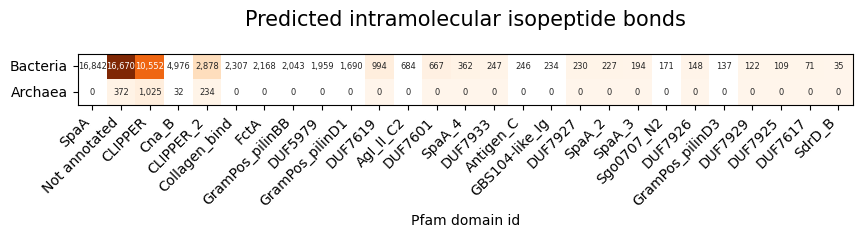

In [7]:
plot_df = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin(["Bacteria", "Archaea"]))].copy()
plot_df["pfamA_id"] = plot_df["pfamA_id"].fillna("Not annotated")
plot_df["pfamA_id"] = plot_df["pfamA_id"].replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"})
plot_df = plot_df.value_counts(["kingdom", "pfamA_id"]).reset_index()\
                 .query('count>=20')\
                 .pivot(index="pfamA_id", columns="kingdom", values="count").fillna(0).astype(int)\
                 [["Bacteria", "Archaea"]]\
                 .sort_values(["Bacteria", "Archaea"], ascending=[False, False]).T\
                 .fillna(0)

known_domains = ['DUF5979', 'AgI_II_C2', 'SpaA', 'Sgo0707_N2', 'GramPos_pilinBB',
       'GramPos_pilinD3', 'Collagen_bind', 'FctA', 'GramPos_pilinD1',
       'Antigen_C', 'GBS104-like_Ig', 'Cna_B']

# Create masks for known domains and non-false positives (columns-based)
known_domains_mask = plot_df.columns.isin(known_domains)

# Separate data into two layers: false positives and non-false positives
false_positives_layer = plot_df.astype(float).copy()
false_positives_layer.loc[:, ~known_domains_mask] = np.nan  # Keep only false positives

non_false_positives_layer = plot_df.astype(float).copy()
non_false_positives_layer.loc[:, known_domains_mask] = np.nan  # Exclude false positives

# Create colormaps with custom "under" or "over" values
cmap_false_positives = plt.get_cmap("Blues").copy()
cmap_false_positives.set_under("none")  # Make non-values invisible

cmap_non_false_positives = plt.get_cmap("Oranges").copy()
cmap_non_false_positives.set_under("none")  # Make non-values invisible

fig, ax = plt.subplots(figsize=[10,5])

sns.heatmap(non_false_positives_layer, cmap=cmap_non_false_positives, 
            ax=ax, annot=True, annot_kws={'fontsize': 6}, fmt=",.0f", cbar=False)

sns.heatmap(false_positives_layer, cmap="Grays", vmin=1, vmax=1,
            ax=ax, annot=True, annot_kws={'fontsize': 6}, fmt=",.0f", cbar=False)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_aspect(0.9)
ax.set_title("Predicted intramolecular isopeptide bonds", fontsize=15, pad=20)
ax.set_ylabel("")
ax.set_xlabel("Pfam domain id")

# Add countour lines
for _, spine in ax.spines.items():
    spine.set_visible(True)

#plt.savefig("../tmp/domain_res_known.png", dpi=400, transparent=True, bbox_inches="tight")

<Axes: xlabel='rmsd', ylabel='Count'>

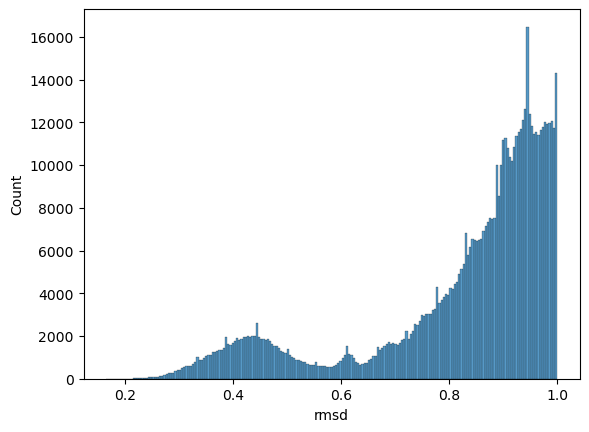

In [9]:
sns.histplot(data=str_df, x="rmsd")

(0.0, 1000.0)

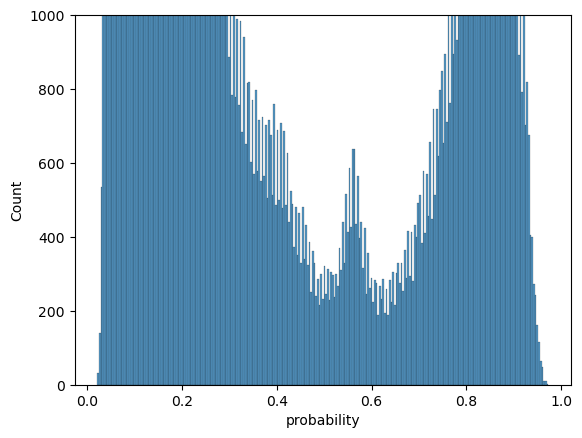

In [5]:
sns.histplot(data=str_df, x="probability")
plt.ylim([0,1000])

<Axes: xlabel='mean_plddt', ylabel='Count'>

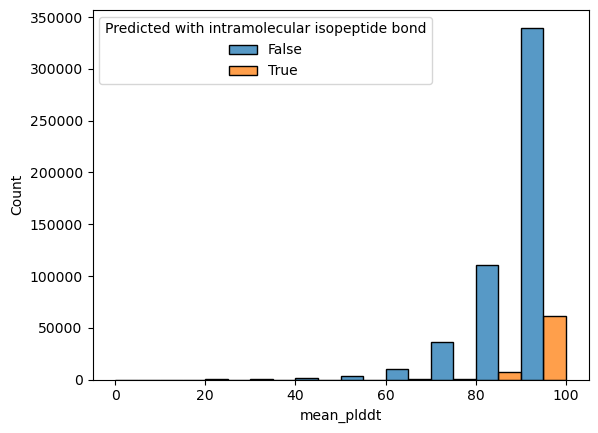

In [10]:
# probability vs plddt
plot_df = str_df[~str_df["taxonomy"].isna()].copy()
plot_df["Predicted with intramolecular isopeptide bond"] = False
plot_df.loc[plot_df["probability"]>.65, "Predicted with intramolecular isopeptide bond"] = True
sns.histplot(data=plot_df, x="mean_plddt", bins=10, binrange=[0,100], 
             hue="Predicted with intramolecular isopeptide bond", multiple="dodge")

In [11]:
kingdom = "Bacteria"

ib_domains = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin([kingdom]))&(~str_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()
# Consider only proteins with isopep bonds
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin([kingdom]))&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()

strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))].value_counts("pfamA_id").iloc[:50]

pfamA_id
Sortase motif      12445
Gram_pos_anchor     4668
Big_8               2392
TQ                  2242
Por_Secre_tail       932
TED                  914
VWA                  655
CHU_C                653
Big_9                621
VWA_2                425
pAdhesive_15         420
MucBP                308
TED_2                291
Bact_lectin          285
QPE                  236
GEVED                235
Adhesin_P1_N         228
Calx-beta            202
DUF6923              200
Flg_new              197
FG-GAP_3             193
SLH                  156
CshA_NR2             152
Ig_7                 150
SprB                 145
DUF5122              138
TSP3_bac             129
HemolysinCabind      125
RCC1                 123
IPTL-CTERM           119
SHIRT                113
SBBP                 111
Fn_bind              110
CshA_repeat          109
WxL                  106
Ice_binding          106
PKD_4                100
Flg_new_2             94
Beta_helix            79
GbpC            

In [12]:
kingdom = "Archaea"

#ib_domains = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin([kingdom]))&(~str_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()
# Consider only proteins with isopep bonds
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin([kingdom]))&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()


print(len(strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))].drop_duplicates("uniprot_acc")))
strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))].value_counts("pfamA_id").iloc[:20]

675


pfamA_id
DUF11              1332
SdrD_B               93
Chlam_PMP            52
HemolysinCabind      43
PKD_4                37
Cna_B                36
SpaA_2               26
Beta_helix           25
DUF4215              17
Big_7                17
SpaA                 16
PGF-CTERM            15
PKD                  15
CarboxypepD_reg      15
Cu-binding_MopE      14
NosD                 13
Big_9                13
BACON_2              13
PQQ                  12
CARDB                12
Name: count, dtype: int64

In [6]:
# How many proteins do not associate with any other domain?


kingdom = "Archaea"

ib_domains = str_df[(str_df["probability"]>.65)&(~str_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()
# Consider only proteins with isopep bonds
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin([kingdom]))&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()

ib_proteins_with_other_domains = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]["uniprot_acc"].unique()
print(len(strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["uniprot_acc"].isin(ib_proteins_with_other_domains))].drop_duplicates("uniprot_acc")))

strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["uniprot_acc"].isin(ib_proteins_with_other_domains))].drop_duplicates("uniprot_acc").iloc[20:40]

463


,uniprot_acc,pfamA_acc,pfamA_id,clan_acc,clan_id,seq_start,seq_end
188218,A0A2I0NW27,PF01345,DUF11,CL0159,E-set,34.0,146.0
188298,A0A1G5XMQ2,PF01345,DUF11,CL0159,E-set,71.0,185.0
188315,A0A3G9D216,PF01345,DUF11,CL0159,E-set,1.0,110.0
188318,A0A832LKW6,PF01345,DUF11,CL0159,E-set,1.0,110.0
188338,A0A843F7D5,PF01345,DUF11,CL0159,E-set,313.0,425.0
188346,A0A368TE33,PF01345,DUF11,CL0159,E-set,187.0,303.0
188414,A0A842KTB3,PF01345,DUF11,CL0159,E-set,365.0,480.0
188417,A0A842L8J2,PF01345,DUF11,CL0159,E-set,365.0,480.0
188465,A0A843IV74,PF01345,DUF11,CL0159,E-set,213.0,326.0
188498,A0A843F8U5,PF01345,DUF11,CL0159,E-set,1.0,98.0


## Presence of sortase motifs

In [50]:
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"]=="Bacteria")&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
sub_df = seq_df[(seq_df["uniprot_acc"].isin(ib_proteins))].copy()
sub_df.value_counts("Sortase", normalize=True)

Sortase
False    0.604051
True     0.395949
Name: proportion, dtype: float64

## Inserted domains

(0.0, 500.0)

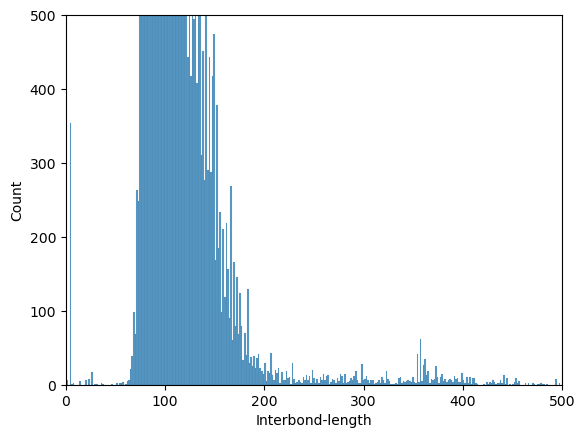

In [45]:
# Get domains with insertions
cond1 = (str_df["probability"]>.65)
cond2 = (~str_df["taxonomy"].isna())
plot_df = str_df[cond1&cond2].copy()
plot_df["Interbond-length"] = plot_df["r2_bond"] - plot_df["r1_bond"]
sns.histplot(plot_df, x="Interbond-length")
plt.xlim([0,500])
plt.ylim([0,500])

In [40]:
# Select bonds with potential insertion
cond1 = (str_df["probability"]>.65)
cond2 = (~str_df["taxonomy"].isna())
idf = str_df[cond1&cond2].copy()
idf["Interbond-length"] = idf["r2_bond"] - idf["r1_bond"]
idf = pd.merge(idf[idf["Interbond-length"]>200][["uniprot_acc", "r1_bond", "r2_bond"]], strd_df, how="left").query('seq_start>=r1_bond&seq_end<=r2_bond')
idf.value_counts("pfamA_id")  

pfamA_id
VWA               369
VWA_2             222
WD40              139
GBS104-like_Ig     45
TED                43
SpaA               36
Big_8              33
SdrG_C_C           21
Big_2              15
pAdhesive_15       11
DUF11               9
PQQ                 6
Lactonase           3
Exo_endo_phos2      3
CBM26               2
CBM_4_9             2
Cna_B               2
P_proprotein        2
Laminin_G_3         2
InhA-like_MAM       2
F5_F8_type_C        1
FctA                1
PA14                1
NIDO                1
Peptidase_S8        1
Name: count, dtype: int64

In [38]:
str_df[(str_df["pfamA_id"]=="SpaA_3")].sort_values("probability")

,struct_file,uniprot_acc,probability,chain,r1_bond,r_cat,r2_bond,r1_bond_name,r_cat_name,r2_bond_name,bond_type,rmsd,r_asa,template,pfamA_acc,pfamA_id,clan_acc,clan_id,seq_start,seq_end,taxonomy,species,kingdom,is_domain,r1_plddt,r2_plddt,r3_plddt,mean_plddt
4337,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A291A5D5,0.096,A,268,326,379,LYS,GLU,ASN,CnaB-like,0.940,0.036,2y1v_A_41_143_184,PF20674,SpaA_3,CL0287,Transthyretin,263.0,381.0,Bacteria; Pseudomonadota; Gammaproteobacteria;...,Lysobacter capsici,Bacteria,True,97.88,98.56,98.12,98.186667
126287,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A7K0M5I5,0.187,A,476,520,568,LYS,GLU,ASN,CnaB-like,0.837,0.033,2xtl_A_355_416_437,PF20674,SpaA_3,CL0287,Transthyretin,495.0,570.0,Bacteria; Actinomycetota; Actinomycetes.,Actinomycetia bacterium,Bacteria,True,89.44,85.75,86.81,87.333333
351113,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A4Q6GH45,0.205,A,133,188,239,LYS,GLU,ASN,CnaB-like,0.825,0.017,3b2m_A_179_258_303,PF20674,SpaA_3,CL0287,Transthyretin,128.0,241.0,Bacteria; Pseudomonadota; Gammaproteobacteria;...,Xanthomonadaceae bacterium,Bacteria,True,93.12,95.06,93.69,93.956667
43154,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A845B862,0.215,A,250,306,362,LYS,GLU,ASN,CnaB-like,0.816,0.023,8f70_A_299_386_437,PF20674,SpaA_3,CL0287,Transthyretin,245.0,364.0,Bacteria; Pseudomonadota; Alphaproteobacteria;...,Allopontixanthobacter sediminis,Bacteria,True,95.31,97.56,97.75,96.873333
287777,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A6H2DQP0,0.219,A,247,303,359,LYS,GLU,ASN,CnaB-like,0.813,0.022,3b2m_A_179_258_303,PF20674,SpaA_3,CL0287,Transthyretin,242.0,361.0,Bacteria; Pseudomonadota; Alphaproteobacteria;...,Parasphingorhabdus halotolerans,Bacteria,True,96.94,97.44,97.81,97.396667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241913,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A852WPJ5,0.880,A,461,519,573,LYS,GLU,ASN,CnaB-like,0.378,0.008,3b2m_A_179_258_303,PF20674,SpaA_3,CL0287,Transthyretin,456.0,575.0,Bacteria; Actinomycetota; Actinomycetes; Micro...,Pedococcus badiiscoriae,Bacteria,True,97.12,97.12,93.06,95.766667
52011,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A1C9U4I8,0.885,A,672,717,766,LYS,GLU,ASN,CnaB-like,0.373,0.006,3gld_A_179_258_303,PF20674,SpaA_3,CL0287,Transthyretin,686.0,768.0,Bacteria; environmental samples.,uncultured bacterium pAX1,Bacteria,True,89.62,95.56,86.50,90.560000
5460,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A291A2P0,0.886,A,497,551,596,LYS,GLU,ASN,CnaB-like,0.369,0.017,7f7y_A_246_328_375,PF20674,SpaA_3,CL0287,Transthyretin,492.0,598.0,Bacteria; Pseudomonadota; Gammaproteobacteria;...,Lysobacter capsici,Bacteria,True,97.81,97.88,97.50,97.730000
311309,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A514BTT6,0.887,A,298,353,409,LYS,GLU,ASN,CnaB-like,0.370,0.005,6bbw_A_163_236_279,PF20674,SpaA_3,CL0287,Transthyretin,293.0,411.0,Bacteria; Pseudomonadota; Gammaproteobacteria;...,Lysobacter alkalisoli,Bacteria,True,98.25,98.31,98.31,98.290000


In [35]:
str_df[(str_df["probability"]>.65)&(str_df["r2_bond_name"]=="ASP")].value_counts("pfamA_id").iloc[:20]

pfamA_id
SpaA               2740
GramPos_pilinD1      45
Ion_trans            10
AsmA                  8
GramPos_pilinD3       6
DUF5979               4
DUF2334               3
Peptidase_C13         2
Glyco_hydro_3         1
Memo                  1
Nrap_D2               1
NB-ARC                1
Name: count, dtype: int64

In [36]:
str_df[str_df["pfamA_id"]=="Ion_trans"].sort_values("probability")


,struct_file,uniprot_acc,probability,chain,r1_bond,r_cat,r2_bond,r1_bond_name,r_cat_name,r2_bond_name,bond_type,rmsd,r_asa,template,pfamA_acc,pfamA_id,clan_acc,clan_id,seq_start,seq_end,taxonomy,species,kingdom,is_domain,r1_plddt,r2_plddt,r3_plddt,mean_plddt
375666,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A034VZ15,0.032,A,103,53,105,LYS,GLU,ASP,CnaB-like,1.000,0.425,5yu5_A_45_145_181,PF00520,Ion_trans,CL0030,Ion_channel,1.0,187.0,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Bactrocera dorsalis (Oriental fruit fly) (Dacu...,Eukaryota,True,87.19,88.31,79.12,84.873333
236689,/hps/nobackup/agb/research/francesco/tmp/jessA...,A1A713,0.036,A,123,73,125,LYS,GLU,ASP,CnaB-like,0.984,0.428,8bdw_A_9_59_91,PF00520,Ion_trans,CL0030,Ion_channel,5.0,207.0,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Drosophila melanogaster (Fruit fly),Eukaryota,True,88.12,88.88,80.94,85.980000
63157,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A0K8UEH0,0.037,A,103,53,105,LYS,GLU,ASP,CnaB-like,0.979,0.433,8bdw_A_9_59_91,PF00520,Ion_trans,CL0030,Ion_channel,1.0,187.0,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Bactrocera latifrons (Malaysian fruit fly) (Ch...,Eukaryota,True,86.44,87.69,79.19,84.440000
27333,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A182K659,0.037,A,246,201,248,LYS,GLU,ASP,CnaB-like,0.979,0.430,8bdw_A_9_59_91,PF00520,Ion_trans,CL0030,Ion_channel,34.0,330.0,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Anopheles christyi,Eukaryota,True,86.31,87.88,77.31,83.833333
246630,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A0J7KFB1,0.041,A,265,305,302,LYS,ASP,ASN,CnaA-like,0.999,0.296,8beg_A_590_636_729,PF00520,Ion_trans,CL0030,Ion_channel,107.0,360.0,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Lasius niger (Black garden ant),Eukaryota,True,87.81,89.06,80.69,85.853333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81882,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A443SN59,0.668,A,200,142,168,LYS,GLU,ASP,CnaB-like,0.551,0.011,5z0z_A_45_145_181,PF00520,Ion_trans,CL0030,Ion_channel,102.0,387.0,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Che...,Leptotrombidium deliense,Eukaryota,True,90.69,88.00,84.56,87.750000
81885,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A218UDN0,0.676,A,193,136,162,LYS,GLU,ASP,CnaB-like,0.539,0.041,5hbb_A_184_269_295,PF00520,Ion_trans,CL0030,Ion_channel,86.0,344.0,Eukaryota; Metazoa; Chordata; Craniata; Verteb...,Lonchura striata domestica (Bengalese finch),Eukaryota,True,90.62,87.62,85.25,87.830000
361068,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A523IXH6,0.680,A,132,74,97,LYS,GLU,ASP,CnaB-like,0.544,0.011,5z0z_A_45_145_181,PF00520,Ion_trans,CL0030,Ion_channel,26.0,244.0,Bacteria; Candidatus Dadabacteria.,Dadabacteria bacterium,Bacteria,True,90.94,86.31,78.88,85.376667
189616,/hps/nobackup/agb/research/francesco/tmp/jessA...,A0A2J8T503,0.681,A,226,169,195,LYS,GLU,ASP,CnaB-like,0.545,0.004,5z0z_A_45_145_181,PF00520,Ion_trans,CL0030,Ion_channel,128.0,436.0,Eukaryota; Metazoa; Chordata; Craniata; Verteb...,Pongo abelii (Sumatran orangutan) (Pongo pygma...,Eukaryota,True,90.44,86.88,85.69,87.670000


## Pilins

Domains found on pilins were obtained through a quick literature search of pilin-containing domains

In [52]:
import sys
sys.path.append("../bin")
from pfamenv import PFAM_HOST,PFAM_PASSWORD,PFAM_PORT,PFAM_USER,PFAM_VERSION
from mysql import connector
import numpy as np

def is_domain(row):
    """

        Assign if at least 2/3 residues are in domain
    
    """
    residues = [row["r1_bond"], row["r_cat"], row["r2_bond"]]
    status = False
    c = 0
    for res in residues:
        if res >= row["seq_start"] and res <= row["seq_end"]:
            c += 1
            #status = True
            #break
    if c >= 2:
        status = True
    return status



In [53]:
# Get pfam info associated with each PDB
columns = ["pdb_id", "pfamA_acc", "pfamA_id", "chain", "pdb_res_start", "pdb_res_end", "seq_start", "seq_end", "clan_acc", "clan_id"]

proteins = pdb_df[(pdb_df["Is bonded"])&(~pdb_df["Interchain"])&(pdb_df["Isopeptide type"]!="Mutant")]["PDB code"].unique()

cnx = connector.connect(user=PFAM_USER,
                        password=PFAM_PASSWORD,
                        port=PFAM_PORT,
                        host=PFAM_HOST)
cursor = cnx.cursor()

proteins_ = ", ".join([f"'{protein}'" for protein in proteins])

# Get domains
cursor.execute(f"SELECT pdb_id,pfamA.pfamA_acc,pfamA.pfamA_id,chain,pdb_res_start,pdb_res_end,seq_start,seq_end,\
                    clan_membership.clan_acc,clan.clan_id \
                 FROM {PFAM_VERSION}.pdb_pfamA_reg, {PFAM_VERSION}.pfamA, \
                     {PFAM_VERSION}.clan_membership, {PFAM_VERSION}.clan \
                 WHERE pdb_id IN ({proteins_}) \
                 AND pfamA.pfamA_acc = clan_membership.pfamA_acc \
                 AND clan.clan_acc=clan_membership.clan_acc \
                 AND pfamA.pfamA_acc = pdb_pfamA_reg.pfamA_acc")
output = cursor.fetchall()
d_df = pd.DataFrame(output, columns = columns)
d_df["pdb_id"] = d_df["pdb_id"].apply(lambda x: x.lower())
data_df = pd.merge(pdb_df, d_df.rename(columns={"pdb_id":"PDB code", "chain":"Chain"}), how="left")\
        .rename(columns={"Position 1\r\n(Bond 1)":"r1_bond", "Position 2\r\n(catalytic)":"r_cat", "Position 3\r\n(Bond 2)":"r2_bond"})

# Check which domains map to isopep bonds
data_df["is_domain"] = data_df.apply(lambda x: is_domain(x), axis=1)
data_df = data_df.sort_values("is_domain", ascending=False) \
        .drop_duplicates(["PDB code", "r1_bond", "r_cat", "r2_bond"], keep="first")
data_df.loc[data_df["is_domain"]==False, "pfamA_acc"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "pfamA_id"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "seq_start"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "seq_end"] = np.NaN
data_df["seq_start"] = data_df["seq_start"].fillna(0).astype(int)
data_df["seq_end"] = data_df["seq_end"].fillna(0).astype(int)
data_df["residues"] = data_df.apply(lambda x: ", ".join([str(_) for _ in [x["r1_bond"], x["r_cat"], x["r2_bond"]]]), axis=1)
data_df["PDB code"] = data_df["PDB code"].apply(lambda x: x.upper())

In [84]:
# Which domains are associated with pilins

pilins = ["SPy_0128", "Spy0125", "BcpA", "SpaA", "SpaE", "SpaD", "T-18.1", "GG-SpaC", "tee"]
pilin_domains = data_df[data_df["Name"].isin(pilins)]["pfamA_acc"].dropna().unique()
data_df[data_df["Name"].isin(pilins)][["pfamA_acc", "pfamA_id", "Name"]].dropna().drop_duplicates()

,pfamA_acc,pfamA_id,Name
176,PF19407,DUF5979,Spy0125
103,PF17802,SpaA,Spy0125
164,PF17802,SpaA,SpaD
165,PF20623,Sgo0707_N2,SpaD
145,PF17802,SpaA,BcpA
265,PF12892,FctA,T-18.1
268,PF19407,DUF5979,T-18.1
273,PF16555,GramPos_pilinD1,SpaE
276,PF17802,SpaA,SpaE
331,PF19407,DUF5979,tee


In [87]:
# What do they associate with

kingdom = "Bacteria"

ib_domains = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin([kingdom]))&(str_df["pfamA_acc"].isin(pilin_domains))]["pfamA_acc"].unique()
# Consider only proteins with isopep bonds
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin([kingdom]))&(str_df["pfamA_acc"].isin(pilin_domains))]["uniprot_acc"].unique()

strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))].value_counts("pfamA_id").iloc[:50]



pfamA_id
Gram_pos_anchor         3573
Cna_B                   2292
GramPos_pilinBB         1875
TQ                      1773
Collagen_bind           1631
Big_8                   1544
TED                      839
DUF11                    378
VWA                      363
pAdhesive_15             347
GBS104-like_Ig           342
TED_2                    243
VWA_2                    223
SdrD_B                   215
GramPos_pilinD3          133
Flg_new                  122
SpaA_3                   114
SpaA_2                   100
GEVED                     99
SHIRT                     95
CshA_NR2                  95
AgI_II_C2                 84
Fn_bind                   82
RCC1                      52
SLH                       48
YSIRK_signal              45
MucBP                     29
Big_9                     26
Sgo0707_N1                24
SdrG_C_C                  24
Big_2                     23
Bact_lectin               19
T6_Ig_like                18
Sortase                   14
DUF69

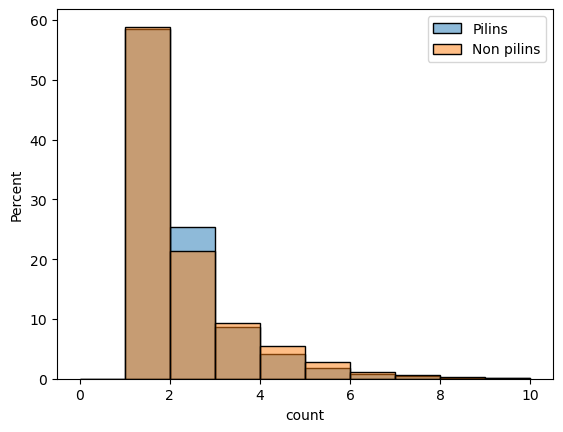

In [89]:
# How many repeats
fig, ax = plt.subplots()

plot_df = str_df[(str_df["probability"]>.65)&(str_df["pfamA_acc"].isin(pilin_domains))].value_counts("uniprot_acc").reset_index()
sns.histplot(plot_df, x="count", stat="percent", bins=10, label="Pilins", binrange=[0,10], alpha=.5)

plot_df = str_df[(str_df["probability"]>.65)&(~str_df["pfamA_acc"].isin(pilin_domains))&(~str_df["pfamA_acc"].isin(non_isopep))].value_counts("uniprot_acc").reset_index()
sns.histplot(plot_df, x="count", stat="percent", bins=10, label="Non pilins", binrange=[0,10], alpha=.5)

ax.legend()


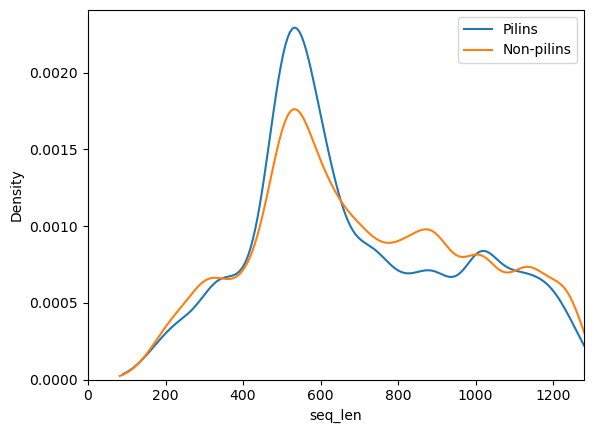

In [90]:
# How long

fig, ax = plt.subplots()

prots = str_df[(str_df["probability"]>.65)&(str_df["pfamA_acc"].isin(pilin_domains))]["uniprot_acc"].unique()
plot_df = seq_df[seq_df["uniprot_acc"].isin(prots)]
sns.kdeplot(plot_df, x="seq_len", cut=0, label="Pilins", ax=ax)

prots = str_df[(str_df["probability"]>.65)&(~str_df["pfamA_acc"].isin(pilin_domains))&(~str_df["pfamA_acc"].isin(non_isopep))]["uniprot_acc"].unique()
plot_df = seq_df[seq_df["uniprot_acc"].isin(prots)]
sns.kdeplot(plot_df, x="seq_len", cut=0, label="Non-pilins", ax=ax)


ax.set_xlim([0,1280])
ax.legend()

## FAL prediction

In [7]:
stalk_df = pd.read_csv(STALK_TABLE).rename(columns={"Pfam ID": "pfamA_acc"})
adh_df = pd.read_csv(ADH_TABLE).rename(columns={"Pfam ID": "pfamA_acc"})
fal_df = pd.read_table(FA_PRED)
p_df = pd.read_csv(PATHOGENS)

In [8]:
s_df = pd.merge(str_df[(str_df["probability"]>.65)&(~str_df["taxonomy"].isna())], 
                fal_df[["ID", "probability_Adh"]].rename(columns={"ID":"uniprot_acc"}))

# Add pathogenic info
s_df["pathogenic"] = 0
s_df.loc[(s_df["species"].str.contains('|'.join(p_df["species"].to_list()))), "pathogenic"] = 1

s_df["who_priority"] = 0
s_df.loc[(s_df["species"].str.contains('|'.join(p_df[(p_df["who_priority"]==1)]["species"].to_list()))), "who_priority"] = 1

/tmp/ipykernel_1222016/2671341230.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  s_df.loc[(s_df["species"].str.contains('|'.join(p_df["species"].to_list()))), "pathogenic"] = 1


In [42]:
# 77% are predicted to be fibrillar adhesins
fal_df.value_counts("prediction", normalize=True).round(2)

prediction
1    0.77
0    0.23
Name: proportion, dtype: float64

In [43]:
fal_df.value_counts("prediction")

prediction
1    25444
0     7605
Name: count, dtype: int64

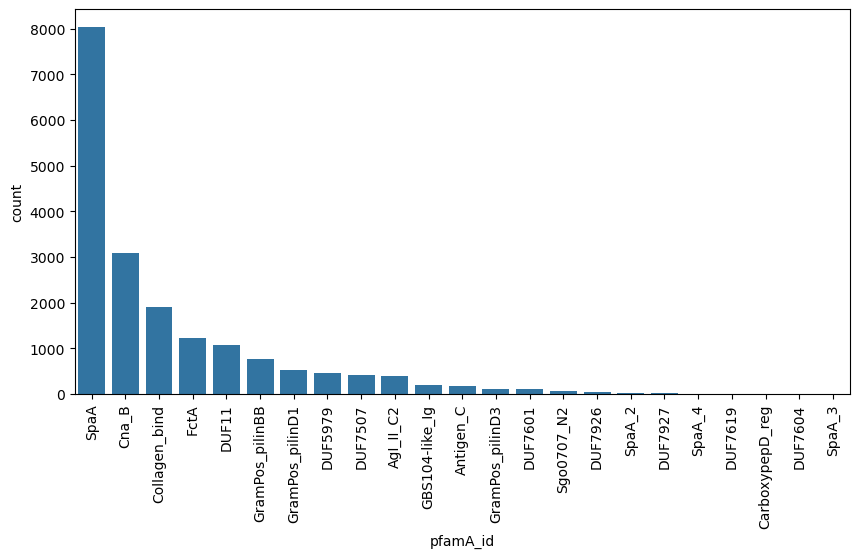

In [45]:
# Which IDP domains are not found in FA?

plot_df = s_df[s_df["probability_Adh"]>.8].value_counts(["pfamA_id"]).iloc[:50].reset_index()

fig, ax = plt.subplots(figsize=[10,5])

g=sns.barplot(plot_df, x="pfamA_id", y="count", ax=ax)
ax.tick_params(axis='x', rotation=90)


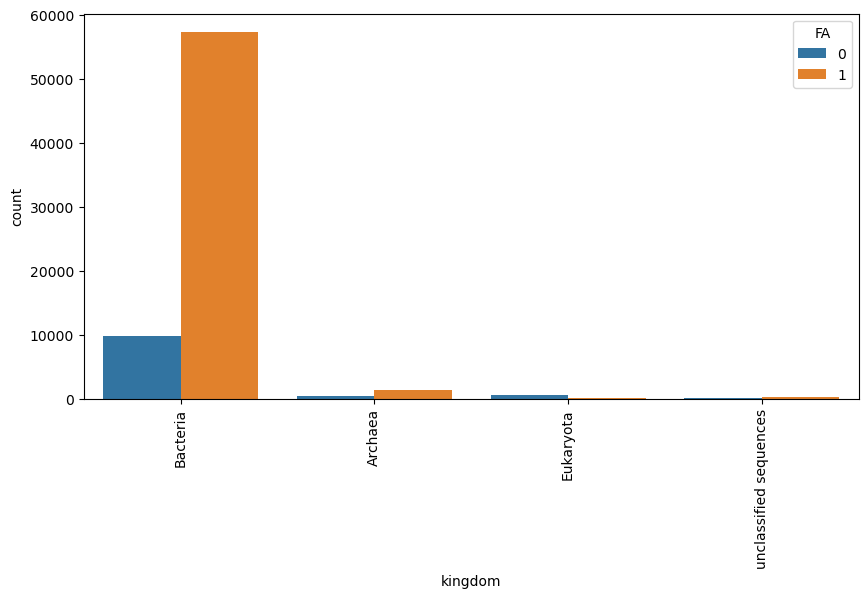

In [48]:
# FA in Bacteria/Archaea

plot_df = s_df.value_counts(["kingdom", "FA"]).reset_index()

fig, ax = plt.subplots(figsize=[10,5])

g=sns.barplot(plot_df, x="kingdom", y="count", hue="FA", ax=ax)
ax.tick_params(axis='x', rotation=90)

/tmp/ipykernel_3390231/3407405337.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])


[Text(0, 0.0, '1.0'),
 Text(0, 0.5, '3.1622776601683795'),
 Text(0, 1.0, '10.0'),
 Text(0, 1.5, '31.622776601683793'),
 Text(0, 2.0, '100.0'),
 Text(0, 2.5, '316.22776601683796'),
 Text(0, 3.0, '1000.0'),
 Text(0, 3.5, '3162.2776601683795'),
 Text(0, 4.0, '10000.0'),
 Text(0, 4.5, '31622.776601683792')]

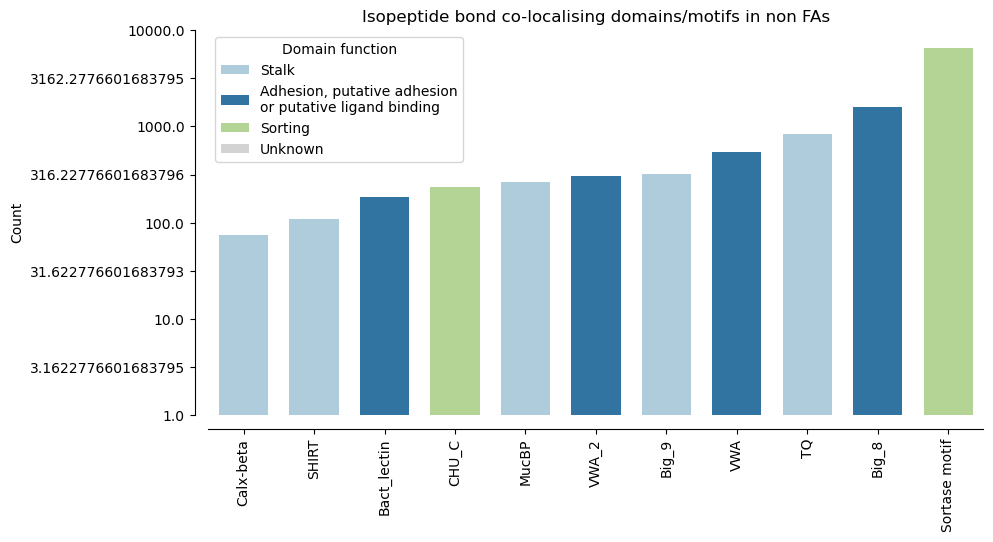

In [46]:
# Which domains co-express with FAs?

# Get domains associated with FA and with non FA
ib_proteins_fa = s_df[(s_df["probability_Adh"]>=.8)&(s_df["kingdom"]\
                        .isin(["Bacteria", "Archaea"]))]["uniprot_acc"].unique()
ib_domains = s_df[(s_df["kingdom"].isin(["Bacteria", "Archaea"]))&(~s_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()

count_df = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins_fa))&(~strd_df["pfamA_acc"].isin(ib_domains))]\
            .value_counts(["pfamA_acc", "pfamA_id"]).reset_index()

adhesin = adh_df["pfamA_acc"].unique()
stalk = stalk_df["pfamA_acc"].unique()
sorting = ["Por_Secre_tail", "CHU_C", "Sortase motif"]
putative_adhesin = ["Big_8", "VWA_2", "FG-GAP_3", "HemolysinCabind", "SprB",
                   "RCC1", "Beta_helix", "RCC1_2", "SBBP", "LTD", "NosD", "FG-GAP_2",
                   "PA", "K319L-like_PKD", "LysM"]

plot_df = count_df.query("count>50").sort_values("count")
plot_df["count"] = plot_df["count"].apply(np.log10)
plot_df["Domain function"] = "Unknown"
# MErge adhesion and putative adhesion
plot_df.loc[plot_df["pfamA_acc"].isin(adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_id"].isin(putative_adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_acc"].isin(stalk), "Domain function"] = "Stalk"
plot_df.loc[plot_df["pfamA_id"].isin(sorting), "Domain function"] = "Sorting"

fig, ax = plt.subplots(figsize=[10,5])

cmap = sns.color_palette("Paired", 3)
g=sns.barplot(plot_df, y="count", x="pfamA_id", 
              palette={"Sorting":cmap[2], 'Stalk':cmap[0], 'Adhesion, putative adhesion\nor putative ligand binding':cmap[1],
                       'Unknown':"lightgray"}, 
              ax=ax, hue="Domain function",
              hue_order=["Stalk", "Adhesion, putative adhesion\nor putative ligand binding", "Sorting", "Unknown"],
             width=.7)
g.tick_params(axis='x', rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("")
ax.set_title("Isopeptide bond co-localising domains/motifs in non FAs")
ax.set_ylabel("Count")
ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])

/tmp/ipykernel_3390231/2209426814.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])


[Text(0, 0.0, '1.0'),
 Text(0, 0.5, '3.1622776601683795'),
 Text(0, 1.0, '10.0'),
 Text(0, 1.5, '31.622776601683793'),
 Text(0, 2.0, '100.0'),
 Text(0, 2.5, '316.22776601683796'),
 Text(0, 3.0, '1000.0'),
 Text(0, 3.5, '3162.2776601683795'),
 Text(0, 4.0, '10000.0')]

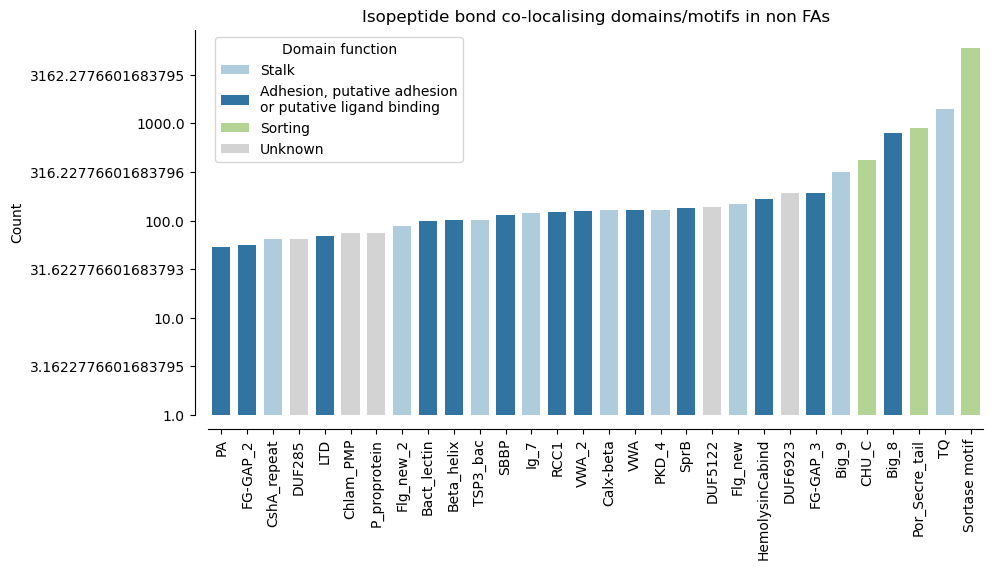

In [48]:
# Which domains co-express with non-FAs?

# Get domains associated with FA and with non FA
ib_proteins_non_fa = s_df[(s_df["probability_Adh"]<.8)&(s_df["kingdom"].isin(["Bacteria", "Archaea"]))]["uniprot_acc"].unique()
ib_domains = s_df[(s_df["kingdom"].isin(["Bacteria", "Archaea"]))&(~s_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()

count_df = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins_non_fa))&(~strd_df["pfamA_acc"].isin(ib_domains))]\
            .value_counts(["pfamA_acc", "pfamA_id"]).reset_index()

adhesin = adh_df["pfamA_acc"].unique()
stalk = stalk_df["pfamA_acc"].unique()
sorting = ["Por_Secre_tail", "CHU_C", "Sortase motif"]
putative_adhesin = ["Big_8", "VWA_2", "FG-GAP_3", "HemolysinCabind", "SprB",
                   "RCC1", "Beta_helix", "RCC1_2", "SBBP", "LTD", "NosD", "FG-GAP_2",
                   "PA", "K319L-like_PKD", "LysM"]

plot_df = count_df.query("count>50").sort_values("count")
plot_df["count"] = plot_df["count"].apply(np.log10)
plot_df["Domain function"] = "Unknown"
# MErge adhesion and putative adhesion
plot_df.loc[plot_df["pfamA_acc"].isin(adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_id"].isin(putative_adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_acc"].isin(stalk), "Domain function"] = "Stalk"
plot_df.loc[plot_df["pfamA_id"].isin(sorting), "Domain function"] = "Sorting"

fig, ax = plt.subplots(figsize=[10,5])

cmap = sns.color_palette("Paired", 3)
g=sns.barplot(plot_df, y="count", x="pfamA_id", 
              palette={"Sorting":cmap[2], 'Stalk':cmap[0], 'Adhesion, putative adhesion\nor putative ligand binding':cmap[1],
                       'Unknown':"lightgray"}, 
              ax=ax, hue="Domain function",
              hue_order=["Stalk", "Adhesion, putative adhesion\nor putative ligand binding", "Sorting", "Unknown"],
             width=.7)
g.tick_params(axis='x', rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("")
ax.set_title("Isopeptide bond co-localising domains/motifs in non FAs")
ax.set_ylabel("Count")
ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])

In [20]:
# How many FA-IBD proteins do pathogens have:

s_df[(s_df["pathogenic"]==1)].drop_duplicates("uniprot_acc").value_counts("FA")

FA
1    2794
0     230
Name: count, dtype: int64

In [27]:
s_df[(s_df["who_priority"]==1)].drop_duplicates("uniprot_acc").value_counts("FA")

FA
1    77
0    17
Name: count, dtype: int64

In [49]:
s_df.to_csv("../tmp/20250212_ib_fa_patho.csv", index=False)

In [52]:
str_df[(str_df["pfamA_id"].isin(
    ["DUF7619", "DUF7601", "DUF7604", "DUF7617", 
     "SpaA_4", "DUF7507", "DUF7926", "DUF7927", 
     "DUF7929", "DUF7925"]))][["pfamA_id", "pfamA_acc"]].drop_duplicates()

,pfamA_id,pfamA_acc
333645,DUF7507,PF24346
334082,DUF7617,PF24593
334397,DUF7619,PF24595
334729,SpaA_4,PF24514
335135,DUF7925,PF25546
335730,DUF7927,PF25549
338331,DUF7604,PF24558
338355,DUF7601,PF24547
338845,DUF7929,PF25551
342849,DUF7926,PF25548


In [9]:
fal_df[fal_df["probability_Adh"]>=.9]

,ID,length,treks_07,Any_anchor,Stalks,Any_adh,frac_disordered,Hydro_portion,Charge_portion,rel_entropy,...,A,V,I,L,M,F,Y,W,prediction,probability_Adh
26,A0A022N5J7,1148,0.0,1.0,3.0,1.0,23.43,0.35,0.25,0.24,...,4.88,6.53,6.18,7.67,0.96,3.75,4.01,1.13,1,1.00
32,A0A023UE45,1220,0.0,1.0,4.0,0.0,36.64,0.35,0.21,0.29,...,6.80,7.30,6.07,5.25,0.90,3.93,4.10,0.16,1,0.94
42,A0A059MXG1,1075,0.0,1.0,5.0,0.0,14.98,0.38,0.26,0.29,...,7.63,7.63,6.05,6.79,1.21,4.09,3.26,1.02,1,0.94
47,A0A059N0V2,628,0.0,1.0,2.0,1.0,17.83,0.36,0.22,0.32,...,4.46,7.48,6.21,8.28,0.80,4.30,4.30,0.64,1,1.00
48,A0A059N1M2,627,0.0,1.0,2.0,0.0,21.69,0.39,0.23,0.35,...,8.45,9.73,4.31,6.70,0.96,3.35,4.78,0.48,1,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33027,X8ISV1,1006,0.0,1.0,4.0,1.0,25.94,0.38,0.23,0.29,...,7.55,11.23,3.38,6.66,1.19,4.08,2.88,0.60,1,1.00
33028,X8IWC7,1239,0.0,0.0,3.0,1.0,31.40,0.36,0.24,0.29,...,8.72,8.39,3.47,5.89,1.37,2.82,3.87,1.05,1,1.00
33030,X8JAJ5,1005,1.0,0.0,3.0,1.0,23.68,0.36,0.28,0.33,...,7.16,8.96,6.07,3.98,1.09,2.99,4.68,0.70,1,1.00
33038,X8KAJ8,1141,1.0,1.0,6.0,0.0,16.91,0.38,0.24,0.42,...,10.43,9.20,3.86,5.61,0.53,3.68,3.94,0.44,1,0.96


In [10]:
4638/len(fal_df)

0.1403370752518987